<a href="https://colab.research.google.com/github/cralji/RFF-Nerve-UTP/blob/main/UNET-Nerve-UTP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Packages

In [ ]:
from sklearn.metrics import silhouette_score, mean_absolute_error, mean_squared_error, confusion_matrix, accuracy_score, classification_report, f1_score, roc_curve, roc_auc_score
from sklearn.model_selection import StratifiedShuffleSplit,train_test_split,GridSearchCV,cross_val_score, cross_val_predict
from sklearn.ensemble import BaggingClassifier,RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.linear_model import LinearRegression,  SGDClassifier, LogisticRegression
from sklearn.tree import DecisionTreeClassifier,export_graphviz
from sklearn.cluster import AgglomerativeClustering, KMeans
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.calibration import CalibratedClassifierCV
from sklearn.feature_selection import RFE, SelectKBest, chi2
from yellowbrick.cluster import SilhouetteVisualizer
from sklearn.preprocessing import StandardScaler
from xml.etree import cElementTree as ElementTree
from keras_preprocessing.image import ImageDataGenerator
from sklearn.externals.six import StringIO  
from sklearn.naive_bayes import GaussianNB
from pandas.plotting import scatter_matrix
from sklearn.decomposition import NMF, TruncatedSVD
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from IPython.display import Image  
import matplotlib.pyplot as plt
from sklearn import metrics 
from joblib import dump, load
import requests, zipfile, io
from sklearn import svm
import numpy as np
from numpy import mean, std
import seaborn as sns
import cv2
import scipy.io
import pandas as pd
import pydotplus
import os
from glob import glob
from PIL import Image
from math import sqrt
from tqdm import tqdm
import tensorflow as tf
import tensorflow.keras
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import Model, load_model
from tensorflow.keras import Input
from tensorflow.keras.layers import Input, Activation, BatchNormalization, Dropout, Lambda, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate
from tensorflow.keras.optimizers import Adam
import skimage
from skimage import segmentation

try:
  !pip install scikit-image
except:
  None

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)


# Functions 

In [ ]:
#%% functionfor extract the image's mask from xml extensión file. 
def fun2(pathxml,pathimg, img_path, label_path,img_path_nerve, label_path_nerve):
  tree = ElementTree.parse(pathxml)
  root = tree.getroot()
  xy=[]
  d={}
  i=0
  for element in root:
    if len(element)==0:
      d[str(element.tag)]=str(element.text)
    else: 
      d[str(element.tag)]={}
    for sub in element:
      if len(sub)==0:
        d[str(element.tag)][str(sub.tag)]=str(sub.text)
      else:
        d[str(element.tag)][str(sub.tag)]={}
      for sub2 in sub:
        if len(sub2)==0:
          d[str(element.tag)][str(sub.tag)][str(sub2.tag)]=str(sub2.text)
        else:
          if str(sub2.tag)=="pt":
            i+=1
            d[str(element.tag)][str(sub.tag)][str(sub2.tag)+str(i)]={"x":sub2[0].text,"y":sub2[1].text}
            xy.append((sub2[0].text,sub2[1].text))
  pts = np.asarray(xy,np.int32)
  img=plt.imread(pathimg)
  img_poly = plt.imread(pathimg)
  img_labels = np.zeros((img[:,:,0].shape),dtype=np.uint8)
  cv2.fillPoly(img_poly,[pts], (255,0,0));  
  indices=np.where(np.all(img_poly== (255,0,0),axis=-1)) 
  img_labels[indices[0],indices[1]] = 1#255#255#1
  
  cv2.imwrite(img_path, img)
  cv2.imwrite(label_path, img_labels)

  cv2.imwrite(img_path_nerve, img)
  cv2.imwrite(label_path_nerve, img_labels)

# Load Data

## Download Dataset

In [ ]:
FILEID = "1GewZspflKFgN7Clut5Xqr3E3CQLSfoYU"
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id='$FILEID -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id="$FILEID -O ImagenesNervios.zip && rm -rf /tmp/cookies.txt

--2021-05-12 21:17:43--  https://docs.google.com/uc?export=download&confirm=6Aim&id=1GewZspflKFgN7Clut5Xqr3E3CQLSfoYU
Resolving docs.google.com (docs.google.com)... 108.177.121.102, 108.177.121.113, 108.177.121.138, ...
Connecting to docs.google.com (docs.google.com)|108.177.121.102|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-00-6s-docs.googleusercontent.com/docs/securesc/7u1r498vrgsr5dhfp05tn7bqg8gpk0v3/6mkira2ia3j1h7tl8am1rjd9j6lr5hir/1620854250000/05137136237839183901/05635816978348367559Z/1GewZspflKFgN7Clut5Xqr3E3CQLSfoYU?e=download [following]
--2021-05-12 21:17:43--  https://doc-00-6s-docs.googleusercontent.com/docs/securesc/7u1r498vrgsr5dhfp05tn7bqg8gpk0v3/6mkira2ia3j1h7tl8am1rjd9j6lr5hir/1620854250000/05137136237839183901/05635816978348367559Z/1GewZspflKFgN7Clut5Xqr3E3CQLSfoYU?e=download
Resolving doc-00-6s-docs.googleusercontent.com (doc-00-6s-docs.googleusercontent.com)... 142.250.128.132, 2607:f8b0:4001:c32::84
Conne

In [ ]:
!unzip ImagenesNervios

Archive:  ImagenesNervios.zip
   creating: ImagenesNervios_/
  inflating: ImagenesNervios_/ciatico_1.png  
  inflating: ImagenesNervios_/ciatico_10.png  
  inflating: ImagenesNervios_/ciatico_100.png  
  inflating: ImagenesNervios_/ciatico_100_mask.png  
  inflating: ImagenesNervios_/ciatico_100_rf.png  
  inflating: ImagenesNervios_/ciatico_100_rf_mask.png  
  inflating: ImagenesNervios_/ciatico_100_uf.png  
  inflating: ImagenesNervios_/ciatico_100_uf_mask.png  
  inflating: ImagenesNervios_/ciatico_101.png  
  inflating: ImagenesNervios_/ciatico_101_mask.png  
  inflating: ImagenesNervios_/ciatico_101_rf.png  
  inflating: ImagenesNervios_/ciatico_101_rf_mask.png  
  inflating: ImagenesNervios_/ciatico_101_uf.png  
  inflating: ImagenesNervios_/ciatico_101_uf_mask.png  
  inflating: ImagenesNervios_/ciatico_102.png  
  inflating: ImagenesNervios_/ciatico_102_mask.png  
  inflating: ImagenesNervios_/ciatico_102_rf.png  
  inflating: ImagenesNervios_/ciatico_102_rf_mask.png  
  inflat

### original

In [ ]:
# r = requests.get('https://github.com/HaroldMDiazVargas/NerveProject/blob/main/ImagenesNervios.zip?raw=true') 
# z = zipfile.ZipFile(io.BytesIO(r.content))
# z.extractall()

In [ ]:
# !mkdir ImagenesNervios/data
# !mkdir ImagenesNervios/ciatico
# !mkdir ImagenesNervios/cubital
# !mkdir ImagenesNervios/mediano
# !mkdir ImagenesNervios/femoral

# nerve = {0:'ciatico',9:'cubital',14:'mediano',17:'femoral'}

# total_img = 0
# nerve_img = 0
# j = 0
# for i in range(22):
  
#   if i == 0 or i == 9 or i == 14 or i == 17:
#     nerve_img = 0
#     act_nerv = nerve[i]
#     j = j+1
#   # path = "P"+str(i+1)+"_"+act_nerv
#   path = "./ImagenesNervios/"+"P"+str(i+1)+"_"+act_nerv+"/"
#   xml_name = [pos_xml for pos_xml in os.listdir(path) if pos_xml.endswith('.xml')]
  
#   for xml_file in xml_name:
#     nerve_img = nerve_img + 1
#     total_img = total_img + 1
#     img_path = "./ImagenesNervios/data/"+act_nerv+'_'+str(total_img)+'.png'
#     label_path = "./ImagenesNervios/data/"+act_nerv+'_'+str(total_img)+'_mask.png'
#     img_path_nerve = "./ImagenesNervios/"+act_nerv+"/"+str(nerve_img)+'.png'
#     label_path_nerve = "./ImagenesNervios/"+act_nerv+"/"+str(nerve_img)+'_mask.png'
#     path_xml = path+xml_file
#     path_img = path+xml_file[0:-4]+".jpg"
#     fun2(path_xml,path_img, img_path, label_path,img_path_nerve, label_path_nerve)

In [ ]:
# !mkdir Images
# !mv ./ImagenesNervios/data/ ./Images/data

## Relocate images and mask

In [ ]:
# file_images = glob('./Images/data/*.png')
file_images = glob('./ImagenesNervios_/*.png')

In [ ]:
file_images.sort()
filepath_image = [] # sólo imagenes
filepath_mask = [] # mascaras
nerve_name = []
for filepath in [filepath_ for filepath_ in file_images if 'mask' not in filepath_]:
  mask = filepath[:-4]+'_mask.png'
  if mask in file_images:
    filepath_image.append(filepath)
    filepath_mask.append(mask)

    if 'ciatico' in filepath:
      nerve_name.append('ciatico')
    elif 'cubital' in filepath:
      nerve_name.append('cubital')
    elif 'femoral' in filepath:
      nerve_name.append('femoral')
    elif 'mediano' in filepath:
      nerve_name.append('mediano')

df = pd.DataFrame({'filepath':filepath_image,'nerve_name':nerve_name,'mask':filepath_mask})
t = df['nerve_name']
df.head()

,filepath,nerve_name,mask
0,./ImagenesNervios_/ciatico_1.png,ciatico,./ImagenesNervios_/ciatico_1_mask.png
1,./ImagenesNervios_/ciatico_10.png,ciatico,./ImagenesNervios_/ciatico_10_mask.png
2,./ImagenesNervios_/ciatico_100.png,ciatico,./ImagenesNervios_/ciatico_100_mask.png
3,./ImagenesNervios_/ciatico_100_rf.png,ciatico,./ImagenesNervios_/ciatico_100_rf_mask.png
4,./ImagenesNervios_/ciatico_100_uf.png,ciatico,./ImagenesNervios_/ciatico_100_uf_mask.png


### Split sets

In [ ]:
df_train_images,df_test_images,t_train,_ = train_test_split(df,t, test_size=0.2,stratify = t)
df_train_images,df_val_images,_,_ = train_test_split(df_train_images,t_train, test_size=0.2,stratify = t_train)

360 x 279


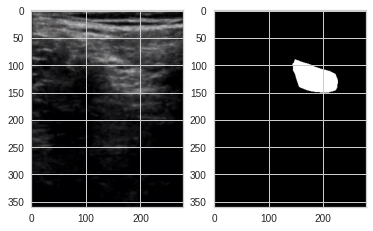

In [ ]:
img = cv2.imread(filepath_image[0])
mask = cv2.imread(filepath_mask[0])
height,width,_ = img.shape
print(height,'x',width)
plt.subplot(1,2,1)
plt.imshow(img)
plt.subplot(1,2,2)
plt.imshow(mask*255,cmap='gray')
plt.show()

### Data generator. 

In [ ]:
df_train_images

,filepath,nerve_name,mask
1390,./ImagenesNervios_/cubital_464_rf.png,cubital,./ImagenesNervios_/cubital_464_rf_mask.png
666,./ImagenesNervios_/ciatico_40_uf.png,ciatico,./ImagenesNervios_/ciatico_40_uf_mask.png
922,./ImagenesNervios_/cubital_308_rf.png,cubital,./ImagenesNervios_/cubital_308_rf_mask.png
120,./ImagenesNervios_/ciatico_136_rf.png,ciatico,./ImagenesNervios_/ciatico_136_rf_mask.png
870,./ImagenesNervios_/cubital_291.png,cubital,./ImagenesNervios_/cubital_291_mask.png
...,...,...,...
1241,./ImagenesNervios_/cubital_414_uf.png,cubital,./ImagenesNervios_/cubital_414_uf_mask.png
1411,./ImagenesNervios_/cubital_471_rf.png,cubital,./ImagenesNervios_/cubital_471_rf_mask.png
732,./ImagenesNervios_/ciatico_60_uf.png,ciatico,./ImagenesNervios_/ciatico_60_uf_mask.png
1662,./ImagenesNervios_/femoral_596.png,femoral,./ImagenesNervios_/femoral_596_mask.png


In [ ]:
def preprocessing_mask(mask):
  mask[mask > 0.5] = 255
  mask[mask <= 0.5] = 0
  return mask

In [ ]:
seed = 1993
batch_size = 32
height,width = 256,256
image_datagen = ImageDataGenerator(rotation_range=10,
                                   horizontal_flip =True,
                                   vertical_flip=True,
                                   rescale=1./255)

image_datagen_mask = ImageDataGenerator(rotation_range=10,
                                   horizontal_flip =True,
                                   vertical_flip=True,
                                   rescale=1./255,
                                   preprocessing_function = preprocessing_mask)

generator_train_img = image_datagen.flow_from_dataframe(df_train_images,
                                                        x_col = 'filepath',
                                                        batch_size = batch_size,
                                                        class_mode = None,
                                                        directory = None,
                                                        target_size = (height,width),
                                                        seed = seed)

generator_train_mask = image_datagen_mask.flow_from_dataframe(df_train_images,
                                                         x_col='mask',
                                                         class_mode = None,
                                                         directory = None,
                                                         color_mode="grayscale", 
                                                         batch_size = batch_size,
                                                         target_size = (height,width),
                                                         seed = seed)

train_gen = zip(generator_train_img,generator_train_mask)


generator_val_img = image_datagen.flow_from_dataframe(df_val_images,
                                                        x_col='filepath',
                                                        class_mode = None,
                                                        directory = None,
                                                        target_size = (height,width),
                                                        batch_size = batch_size,
                                                        seed = seed)

generator_val_mask = image_datagen_mask.flow_from_dataframe(df_val_images,
                                                         x_col='mask',
                                                         class_mode = None,
                                                         directory = None,
                                                         color_mode="grayscale",
                                                         target_size = (height,width),
                                                         batch_size = batch_size,
                                                         seed = seed)

val_gen = zip(generator_val_img,generator_val_mask)


generator_test_img = image_datagen.flow_from_dataframe(df_test_images,
                                                        x_col='filepath',
                                                        class_mode = None,
                                                        directory = None,
                                                        target_size = (height,width),
                                                        batch_size = batch_size,
                                                        seed = seed)

generator_test_mask = image_datagen_mask.flow_from_dataframe(df_test_images,
                                                         x_col='mask',
                                                         class_mode = None,
                                                         directory = None,
                                                         color_mode="grayscale",
                                                         target_size = (height,width),
                                                         batch_size = batch_size,
                                                         seed = seed)

test_gen = zip(generator_test_img,generator_test_mask)


Found 1188 validated image filenames.
Found 1188 validated image filenames.
Found 297 validated image filenames.
Found 297 validated image filenames.
Found 372 validated image filenames.
Found 372 validated image filenames.


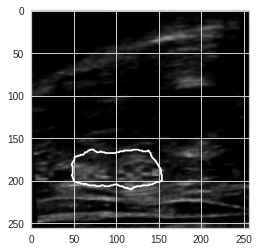

In [ ]:
i,j = next(train_gen)

plt.imshow(i[0,:,:,:])
edges_est = segmentation.clear_border(j[0,:,:,0]) # H_image x w_image
plt.contour(edges_est,[0.5]) # H_image x w_image 1 if pixels is nerve's border
plt.show()

# Build Model 

## need functions

In [ ]:
def dice_coef(y_true, y_pred, smooth = 1.):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def renny_entropy(ytrue,ypred):
    Ke = tf.matmul(ypred,ypred,transpose_b=True)
    Ke = Ke/tf.linalg.trace(Ke)
    #entropy_renny  = (1/(1-2))*tf.math.log((1/tf.constant(32*32,dtype=ypred.dtype))*tf.linalg.trace(tf.matmul(Ke,Ke,transpose_a=True)))
    entropy_renny = tf.constant(1/(1-2))*tf.linalg.trace(tf.matmul(Ke,Ke,transpose_a=True))
    return entropy_renny


def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

def iou(y_true, y_pred, smooth = 1.):
    intersection = K.sum(y_true * y_pred)
    sum_ = K.sum(y_true) + K.sum(y_pred)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return jac

def iou_np(mask,mask_est,smooth=1):
  inter = np.sum(mask*mask_est)
  sum__ = np.sum(mask) + np.sum(mask_est)
  return (inter + smooth)/(sum__ - inter + smooth)

def sensitivity(y_true, y_pred):
    s = K.sum(y_true, axis=(1,2,3))
    y_true_c = s / (s + K.epsilon())
    s_ = K.sum(y_pred, axis=(1,2,3))
    y_pred_c = s_ / (s_ + K.epsilon())
   
    true_positives = K.sum(K.round(K.clip(y_true_c * y_pred_c, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true_c, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())

def specificity(y_true, y_pred):
    s = K.sum(y_true, axis=(1,2,3))
    y_true_c = s / (s + K.epsilon())
    s_ = K.sum(y_pred, axis=(1,2,3))
    y_pred_c = s_ / (s_ + K.epsilon())
    
    true_negatives = K.sum(K.round(K.clip((1-y_true_c) * (1-y_pred_c), 0, 1)))#123456789
# path = "./ImagenesNervios/data/"data_image = [] data_mask = glob(path + '*_mask*') for i in data_mask:  data_image.append(i.replace('_mask', '')) print("Cantidad total de datos:",len(data_image))

    possible_negatives = K.sum(K.round(K.clip(1-y_true_c, 0, 1)))
    return true_negatives / (possible_negatives + K.epsilon())

In [ ]:
UPSAMPLE_MODE = 'SIMPLE' # SIMPLE'
NET_SCALING = None
GAUSSIAN_NOISE = 0.1
EDGE_CROP = 16
ACTIVATION = 'relu'
from tensorflow.keras import models, layers
from tensorflow.keras.layers.experimental import RandomFourierFeatures
# Build U-Net model
def upsample_conv(filters, kernel_size, strides, padding):
    return layers.Conv2DTranspose(filters, kernel_size, strides=strides, padding=padding)
def upsample_simple(filters, kernel_size, strides, padding):
    return layers.UpSampling2D(strides)

if UPSAMPLE_MODE=='DECONV':
    upsample=upsample_conv
else:
    upsample=upsample_simple

def create_model(phi_units = 128):
  input_img = layers.Input((width,height,3), name = 'RGB_Input')
  pp_in_layer = input_img
  if NET_SCALING is not None:
      pp_in_layer = layers.AvgPool2D(NET_SCALING)(pp_in_layer)
      
  # pp_in_layer = layers.GaussianNoise(GAUSSIAN_NOISE)(pp_in_layer)
  pp_in_layer = layers.BatchNormalization()(pp_in_layer)

  c1 = layers.Conv2D(8, (3, 3), activation=ACTIVATION, padding='same') (pp_in_layer)
  c1 = layers.Conv2D(8, (3, 3), activation=ACTIVATION, padding='same') (c1)
  p1 = layers.MaxPooling2D((2, 2)) (c1)

  c2 = layers.Conv2D(16, (3, 3), activation=ACTIVATION, padding='same') (p1)
  c2 = layers.Conv2D(16, (3, 3), activation=ACTIVATION, padding='same') (c2)
  p2 = layers.MaxPooling2D((2, 2)) (c2)

  c3 = layers.Conv2D(32, (3, 3), activation=ACTIVATION, padding='same') (p2)
  c3 = layers.Conv2D(32, (3, 3), activation=ACTIVATION, padding='same') (c3)
  p3 = layers.MaxPooling2D((2, 2)) (c3)

  c4 = layers.Conv2D(64, (3, 3), activation=ACTIVATION, padding='same') (p3)
  c4 = layers.Conv2D(64, (3, 3), activation=ACTIVATION, padding='same') (c4)
  p4 = layers.MaxPooling2D(pool_size=(2, 2)) (c4)

  c5 = layers.Conv2D(128, (3, 3), activation=ACTIVATION, padding='same') (p4)
  c5 = layers.Conv2D(128, (3, 3), activation=ACTIVATION, padding='same') (c5)

  u6 = upsample(64, (2, 2), strides=(2, 2), padding='same') (c5)
  u6 = layers.concatenate([u6, c4])
  c6 = layers.Conv2D(64, (3, 3), activation=ACTIVATION, padding='same') (u6)
  c6 = layers.Conv2D(64, (3, 3), activation=ACTIVATION, padding='same') (c6)

  u7 = upsample(32, (2, 2), strides=(2, 2), padding='same') (c6)
  u7 = layers.concatenate([u7, c3])
  c7 = layers.Conv2D(32, (3, 3), activation=ACTIVATION, padding='same') (u7)
  c7 = layers.Conv2D(32, (3, 3), activation=ACTIVATION, padding='same') (c7)

  u8 = upsample(16, (2, 2), strides=(2, 2), padding='same') (c7)
  u8 = layers.concatenate([u8, c2])
  c8 = layers.Conv2D(16, (3, 3), activation=ACTIVATION, padding='same') (u8)
  c8 = layers.Conv2D(16, (3, 3), activation=ACTIVATION, padding='same') (c8)

  u9 = upsample(8, (2, 2), strides=(2, 2), padding='same') (c8)
  u9 = layers.concatenate([u9, c1], axis=3)
  c9 = layers.Conv2D(8, (3, 3), activation=ACTIVATION, padding='same') (u9)
  c9 = layers.Conv2D(8, (3, 3), activation=ACTIVATION, padding='same') (c9)

  d = layers.Conv2D(1, (1, 1), activation='sigmoid') (c9)
  d = layers.Cropping2D((EDGE_CROP, EDGE_CROP))(d)
  d = layers.ZeroPadding2D((EDGE_CROP, EDGE_CROP),name='output')(d)
  if NET_SCALING is not None:
      d = layers.UpSampling2D(NET_SCALING)(d)

  seg_model = models.Model(inputs=[input_img], outputs=[d])
  
  return seg_model

seg_model = create_model(65)

seg_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
RGB_Input (InputLayer)          [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 256, 256, 3)  12          RGB_Input[0][0]                  
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 8)  224         batch_normalization[0][0]        
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 8)  584         conv2d[0][0]                     
______________________________________________________________________________________________

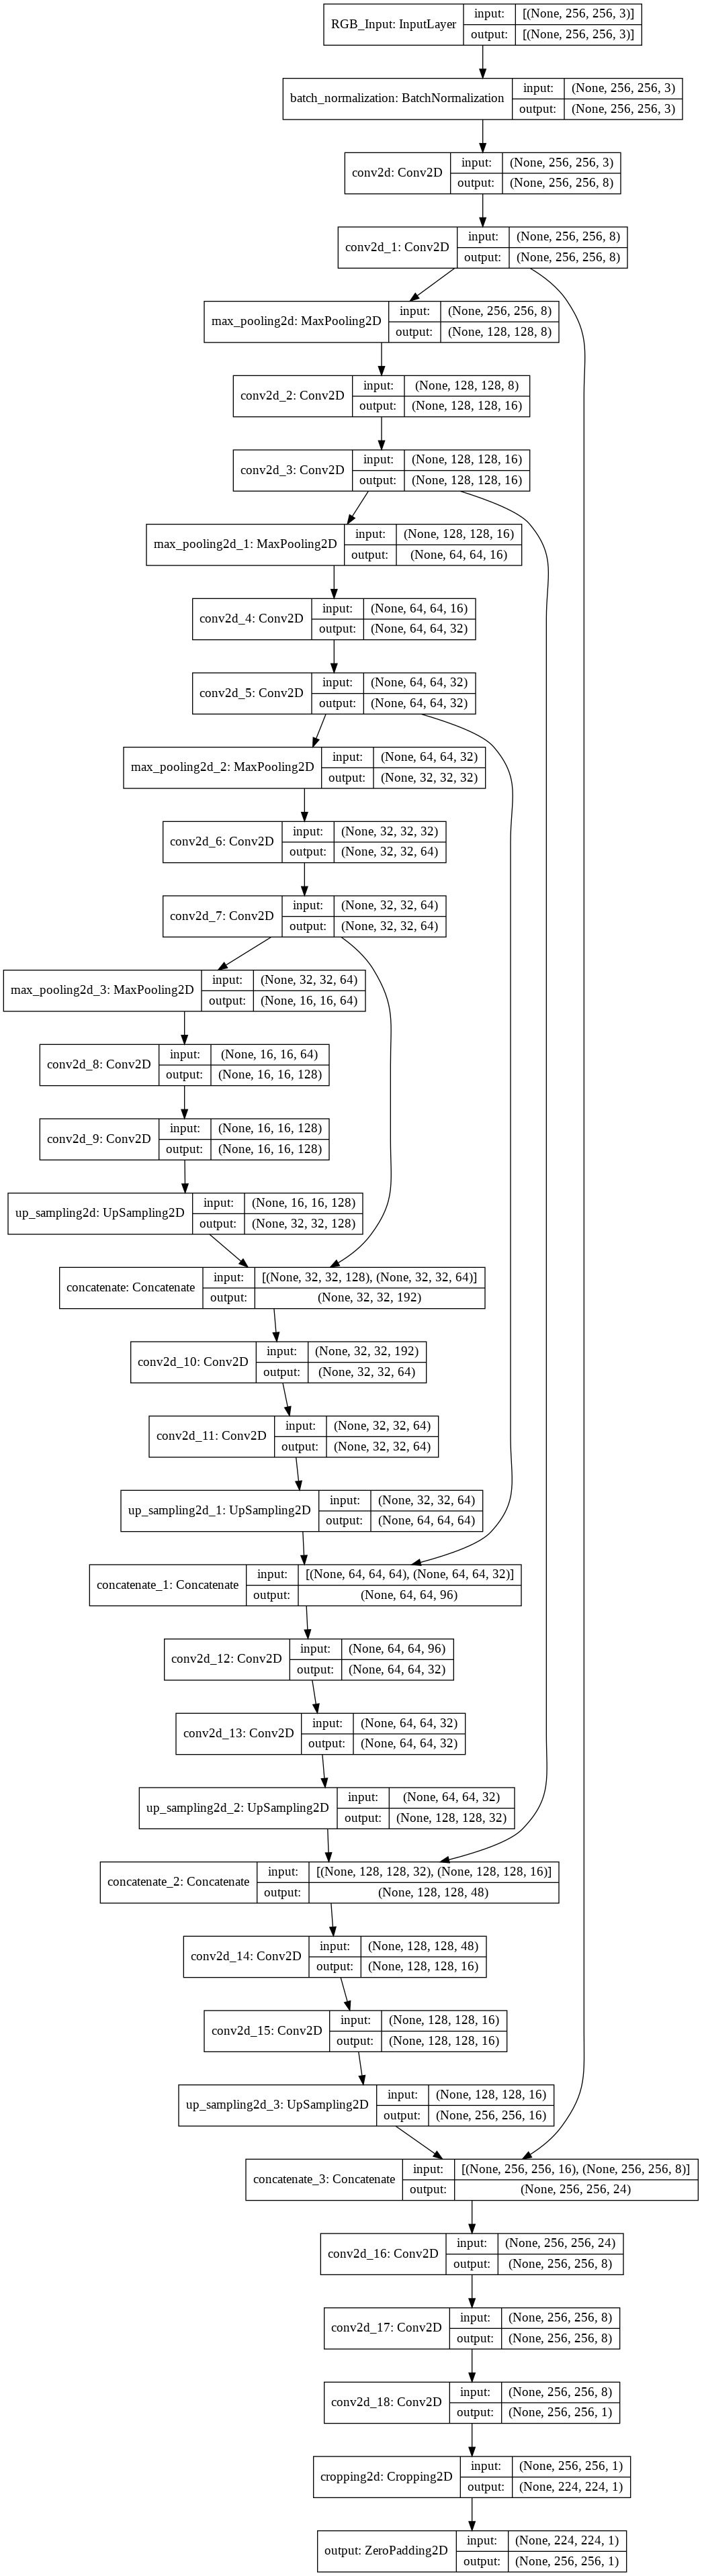

In [ ]:
tf.keras.utils.plot_model(seg_model,show_shapes=True)

Epoch 1/200
37/37 [==============================] - 49s 827ms/step - loss: -0.1782 - iou: 0.0986 - dice_coef: 0.1787 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.4506 - val_loss: -0.3241 - val_iou: 0.1943 - val_dice_coef: 0.3241 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.8266
INFO:tensorflow:Assets written to: results_a-1_phi-units-0/Model_Checkpoint/assets
Epoch 2/200
37/37 [==============================] - 30s 817ms/step - loss: -0.3740 - iou: 0.2326 - dice_coef: 0.3744 - sensitivity: 1.0000 - specificity: 0.0000e+00 - binary_accuracy: 0.8973 - val_loss: -0.4677 - val_iou: 0.3077 - val_dice_coef: 0.4677 - val_sensitivity: 1.0000 - val_specificity: 0.0000e+00 - val_binary_accuracy: 0.9206
INFO:tensorflow:Assets written to: results_a-1_phi-units-0/Model_Checkpoint/assets
Epoch 3/200
37/37 [==============================] - 29s 814ms/step - loss: -0.4874 - iou: 0.3283 - dice_coef: 0.4874 - sensitivity: 1.0000 - specificity:

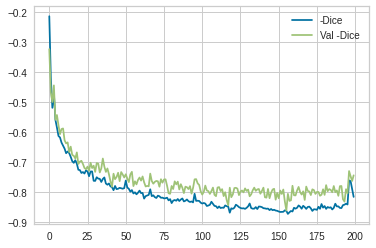

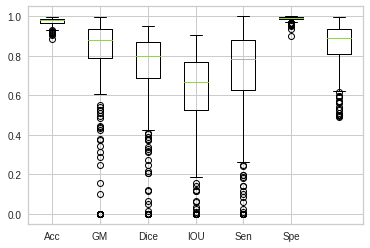

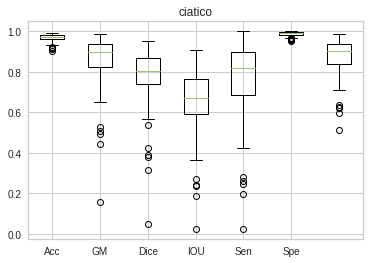

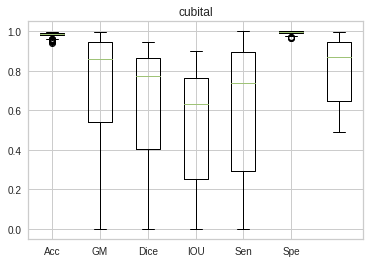

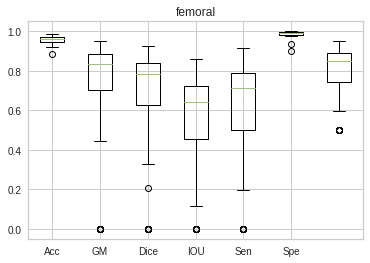

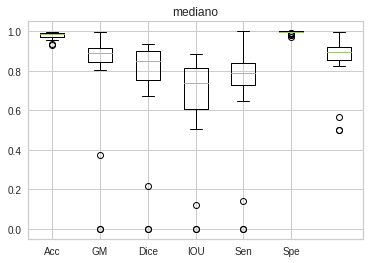

In [ ]:
from sklearn.metrics import accuracy_score,balanced_accuracy_score,f1_score,roc_auc_score,confusion_matrix,recall_score
from joblib import dump
import pandas as pd
import os

EPOCHS = 200
BATCH_SIZE = batch_size

a = 1
phi_units = 0
metrics = [iou, dice_coef, sensitivity, specificity, 'binary_accuracy']

excel_write = pd.ExcelWriter('results.xlsx')


results_template = 'results_a-{}_phi-units-{}' # string template
basepath = results_template.format(a,phi_units)
os.mkdir(basepath)

tf.keras.backend.clear_session()

seg_model = create_model(phi_units)

seg_model.compile(optimizer=Adam(lr=1e-3),
                  loss={'output':dice_coef_loss},
                  metrics = metrics)

callbacks = [tf.keras.callbacks.ModelCheckpoint(basepath+'/Model_Checkpoint',
                                                monitor='val_output_loss',
                                                verbose=0,
                                                mode = 'min')]

history = seg_model.fit(train_gen,
                        steps_per_epoch=len(df_train_images) // BATCH_SIZE, 
                        epochs=EPOCHS , 
                        callbacks=callbacks,
                        validation_data = val_gen,
                        validation_steps=len(df_val_images) // BATCH_SIZE)

# seg_model = tf.keras.Model(inputs = [seg_model.input],outputs=[seg_model.output[0]])


plt.plot(history.history['loss'],label = '-Dice')
plt.plot(history.history['val_loss'],label = 'Val -Dice')
plt.legend()
plt.savefig(basepath+'/LearningCurve.png')
plt.show()


seg_model.save(basepath+'/model.h5')
## Calculo de metricas de rendimiento. 


filesname = df_test_images['filepath'].to_list()
masks_files = df_test_images['mask'].to_list()
test_t = df_test_images['nerve_name'].to_list()

Acc = []
Dice = []
GM = []
Sen = []
Spe = []
AUC = []
CM = []
IOU = []
for path_file,mask_file in zip(filesname,masks_files):
  image1 = np.array(Image.open(path_file).resize((height,width)))
  mask = np.array(Image.open(mask_file).resize((height,width))).reshape(-1,)
  mask_est = np.squeeze(seg_model.predict(np.expand_dims(image1,0)/255).astype(np.uint8)).reshape(-1,)
  CM.append(confusion_matrix(mask,mask_est,labels=[0,1]))
  Acc.append(accuracy_score(mask,mask_est))
  sen = recall_score(mask,mask_est,pos_label=1)
  spe = recall_score(mask,mask_est,pos_label=0)
  Sen.append(sen)
  Spe.append(spe)
  GM.append(sqrt(sen*spe))
  Dice.append(f1_score(mask,mask_est,pos_label=1))
  AUC.append(roc_auc_score(mask,mask_est))
  IOU.append(iou_np(mask,mask_est))

mdict = {'Acc':Acc,
        'GM': GM,
        'IOU':IOU,
        'Dice':Dice,
        'AUC':AUC,
        'Sen':Sen,
        'Spe':Spe,
        'nerve_name':test_t}

pd.DataFrame(mdict).to_excel(excel_write,sheet_name='a-{}__phi-{}'.format(a,phi_units))

plt.boxplot([Acc,GM,Dice,IOU,Sen,Spe,AUC])
plt.xticks([1,2,3,4,5,6],['Acc','GM','Dice','IOU','Sen','Spe','AUC'])
plt.savefig(basepath+'/Boxplot_all')
plt.show()

for name_nerve in ['ciatico','cubital','femoral','mediano']:
  Acc_aux = [Acc[i] for i in range(len(Acc)) if test_t[i]==name_nerve]
  Sen_aux = [Sen[i] for i in range(len(Acc)) if test_t[i]==name_nerve]
  Spe_aux = [Spe[i] for i in range(len(Acc)) if test_t[i]==name_nerve]
  Dice_aux = [Dice[i] for i in range(len(Acc)) if test_t[i]==name_nerve]
  GM_aux = [GM[i] for i in range(len(Acc)) if test_t[i]==name_nerve]
  AUC_aux = [AUC[i] for i in range(len(Acc)) if test_t[i]==name_nerve]
  IOU_aux = [IOU[i] for i in range(len(Acc)) if test_t[i]==name_nerve]
  plt.boxplot([Acc_aux,GM_aux,Dice_aux,IOU_aux,Sen_aux,Spe_aux,AUC_aux])
  plt.xticks([1,2,3,4,5,6],['Acc','GM','Dice','IOU','Sen','Spe','AUC'])
  plt.title(name_nerve)
  plt.savefig(basepath+'/Boxplot_{}'.format(name_nerve))
  plt.show()

savedata = {'Acc':Acc,
            'GM':GM,
            'Dice':Dice,
            'Sen':Sen,
            'Spe':Spe,
            'AUC':AUC,
            'IOU':IOU,
            'CM':CM,
            'train':df_train_images.to_dict(),
            'test':df_test_images.to_dict(),
            'val':df_val_images.to_dict()}
dump(savedata,basepath+'/results.joblib')

excel_write.save()


In [ ]:
!zip -r results ./results* model.png


  adding: results_a-1_phi-units-0/ (stored 0%)
  adding: results_a-1_phi-units-0/results.joblib (deflated 75%)
  adding: results_a-1_phi-units-0/Boxplot_cubital.png (deflated 14%)
  adding: results_a-1_phi-units-0/LearningCurve.png (deflated 4%)
  adding: results_a-1_phi-units-0/Boxplot_ciatico.png (deflated 10%)
  adding: results_a-1_phi-units-0/model.h5 (deflated 10%)
  adding: results_a-1_phi-units-0/Boxplot_femoral.png (deflated 13%)
  adding: results_a-1_phi-units-0/Boxplot_mediano.png (deflated 11%)
  adding: results_a-1_phi-units-0/Boxplot_all.png (deflated 10%)
  adding: results_a-1_phi-units-0/Model_Checkpoint/ (stored 0%)
  adding: results_a-1_phi-units-0/Model_Checkpoint/saved_model.pb (deflated 90%)
  adding: results_a-1_phi-units-0/Model_Checkpoint/assets/ (stored 0%)
  adding: results_a-1_phi-units-0/Model_Checkpoint/variables/ (stored 0%)
  adding: results_a-1_phi-units-0/Model_Checkpoint/variables/variables.index (deflated 75%)
  adding: results_a-1_phi-units-0/Model_Ch

In [ ]:
from google.colab import files
files.download('results.xlsx')
files.download('results.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>